# Movie Dataset Analysis
By Gabriel Garcez Barros Sousa

Dataset acquired from [GroupLens](http://grouplens.org/datasets/movielens/)

<hl>

## 0. Acquiring the Data

To acquire and extract the data, simply run the following Bash scripts:

In [41]:
!wget -O moviedataset.zip http://files.grouplens.org/datasets/movielens/ml-latest.zip

--2016-05-30 18:20:22--  http://files.grouplens.org/datasets/movielens/ml-latest.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.34.146
Connecting to files.grouplens.org (files.grouplens.org)|128.101.34.146|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160301210 (153M) [application/zip]
Saving to: ‘moviedataset.zip’

100%[======================================>] 160,301,210 57.6MB/s   in 2.7s   

2016-05-30 18:20:25 (57.6 MB/s) - ‘moviedataset.zip’ saved [160301210/160301210]



In [36]:
!unzip moviedataset.zip -d /resources

Archive:  moviedataset.zip
   creating: /resources/ml-latest/
  inflating: /resources/ml-latest/links.csv  
  inflating: /resources/ml-latest/movies.csv  
  inflating: /resources/ml-latest/ratings.csv  
  inflating: /resources/ml-latest/README.txt  
  inflating: /resources/ml-latest/tags.csv  


Now you're ready to start working with the data!

## 1. Preprocessing

First, let's get all of the imports out of the way:

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.html.widgets import interact
import time
from IPython.display import display, HTML
%matplotlib inline
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 200)

Now let's read each file into their Dataframes:

In [40]:
movies_df = pd.read_csv('/resources/ml-latest/movies.csv')
ratings_df = pd.read_csv('/resources/ml-latest/ratings.csv')

/resources/ml-latest/ratings.csvLet's also take a peek at how each of them are organized:

In [3]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


So each movie has a unique ID, a title with its release year along with it (Which may contain unicode characters) and several different genres in the same field. Let's remove the year from the title column and place it into its own one by using the handy [extract](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.extract.html#pandas.Series.str.extract) function that Pandas has.

First, let's convert the unicode characters into ASCII to avoid issues in the future by decoding unicode and then encoding it into ASCII.

In [4]:
movies_df['title'] = movies_df['title'].apply(lambda x: x.decode('unicode_escape').encode('ascii', 'ignore').strip())

Let's also remove the year from the title column by using pandas' replace function and make it so the index for this dataframe is movieId.

In [5]:
movies_df['year'] = movies_df.title.str.extract('(\(\d\d\d\d\))')
movies_df['year'] = movies_df.year.str.extract('(\d\d\d\d)')
movies_df['title'] = movies_df.title.str.replace('(\(\d\d\d\d\))', '')
movies_df = movies_df.set_index('movieId')

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  from IPython.kernel.zmq import kernelapp as app


Let's look at the result!

In [6]:
movies_df.head()

,title,genres,year
movieId,,,
1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
2,Jumanji,Adventure|Children|Fantasy,1995
3,Grumpier Old Men,Comedy|Romance,1995
4,Waiting to Exhale,Comedy|Drama|Romance,1995
5,Father of the Bride Part II,Comedy,1995


With that, let's also split the values in the Genres column into a list of Genres to simplify future use. This can be achieved by applying Python's split string function on the correct column.

In [7]:
movies_df['genres'] = movies_df.genres.str.split('|')
movies_df.head()

,title,genres,year
movieId,,,
1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
2,Jumanji,"[Adventure, Children, Fantasy]",1995
3,Grumpier Old Men,"[Comedy, Romance]",1995
4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
5,Father of the Bride Part II,[Comedy],1995


<br>

<br>

Now, let's take a peek at the ratings dataframe.

In [8]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,169,2.5,1204927694
1,1,2471,3.0,1204927438
2,1,48516,5.0,1204927435
3,2,2571,3.5,1436165433
4,2,109487,4.0,1436165496


Every row in the ratings dataframe has a user id associated with at least one movie, a rating and a timestamp showing when they reviewed it. The timestamp column is in a format that counts how many second have gone by since January 1st, 1970.

In [9]:
ratings_df = ratings_df.set_index('userId')

Now let's look at how the ratings Dataframe looks like:

In [10]:
ratings_df.head()

,movieId,rating,timestamp
userId,,,
1,169,2.5,1204927694
1,2471,3.0,1204927438
1,48516,5.0,1204927435
2,2571,3.5,1436165433
2,109487,4.0,1436165496


## 2. Questions

Now, with all that preprocessing out of the way, let's see what we can extract from the data.

#### 2.1. What are the best movies by year?

To do this, we first need to get the average score for every movie and count the amount of users that have reviewed it. This can be accomplished by using the aggregate function to run the mean and count function on each newly formed group.

In [11]:
ratingsGroup = ratings_df.groupby(["movieId"])["rating"].agg(['mean','count'])

In [12]:
ratingsGroup.head()

,mean,count
movieId,,
1,3.894802,60424
2,3.221086,23950
3,3.180094,15267
4,2.879727,2935
5,3.080811,14769


Let's also rename the columns, since mean and count aren't good names.

In [13]:
ratingsGroup.columns = ['average rating', 'number of ratings']
ratingsGroup.head()

,average rating,number of ratings
movieId,,
1,3.894802,60424
2,3.221086,23950
3,3.180094,15267
4,2.879727,2935
5,3.080811,14769


After that, we have to join this new series with the original movies dataframe:

In [14]:
ratedMovies_df = ratingsGroup.join(movies_df)

Let's take a look at the result:

In [15]:
ratedMovies_df.head()

,average rating,number of ratings,title,genres,year
movieId,,,,,
1,3.894802,60424,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
2,3.221086,23950,Jumanji,"[Adventure, Children, Fantasy]",1995
3,3.180094,15267,Grumpier Old Men,"[Comedy, Romance]",1995
4,2.879727,2935,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
5,3.080811,14769,Father of the Bride Part II,[Comedy],1995


Now let's write a function that can extract the best movie for a given year from our dataframe.

This can be achieved by finding the subset of films that contain the given year and then finding a subset that contains the movies with the highest rating for that year. This can be achieved like so:

In [16]:
def getBestMovieByYear(year):
    ratedMoviesForYear = ratedMovies_df.loc[ratedMovies_df.year == str(year)]
    display(ratedMoviesForYear.loc[ratedMovies_df['average rating'] == ratedMoviesForYear['average rating'].max()])

getBestMovieByYear(1995)

,average rating,number of ratings,title,genres,year
movieId,,,,,
72235,5.0,1,Between the Devil and the Deep Blue Sea,[Drama],1995
92956,5.0,1,Little Criminals,"[Crime, Drama]",1995
136876,5.0,1,The Village Had No Walls,[(no genres listed)],1995
140379,5.0,1,The Face on the Milk Carton,[(no genres listed)],1995
151573,5.0,1,What a Mess!,[Comedy],1995


Now let's make it interactive so we don't have to type in a year every time. We can achieve this by using IPython's interact function. This function manifests itself differently depending on the type of input. We need a sliding bar since we're only using a given range of movies, so we can simply supply (1874,2016,1) to achieve this. These numbers specifiy the range of oldest and newest year of movie releases in our dataframe.

In [17]:
interact(getBestMovieByYear, year=(1874,2016,1))

,average rating,number of ratings,title,genres,year
movieId,,,,,
138935,5.0,1,Two O'Clock Courage,"[Crime, Drama, Mystery]",1945


<function __main__.getBestMovieByYear>

As we can see from the results, most of the highest rated movies are simply obscure movies with a low amount of ratings.

#### 2.2. What's the best year for movies by ratings?

To do this, we simply have to take the mean of the average ratings for each year and choose the one with the highest mean and then print it:

In [18]:
yearRatingGroup = ratedMovies_df.groupby(['year'])['average rating'].mean()
bestYear = yearRatingGroup.idxmax()

In [19]:
print("Year with highest average rating: " + bestYear)

Year with highest average rating: 1902


Let's also plot out graphs showing the average rating for each and the amount of ratings per year for the sake of comparison:

In [20]:
yearCountGroup = ratedMovies_df.groupby(['year'])['number of ratings'].sum()

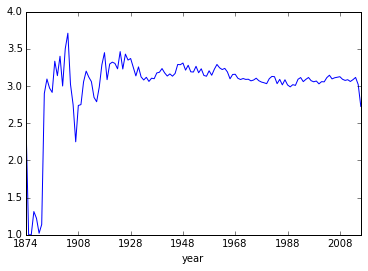

In [21]:
yearRatingGroup.plot()

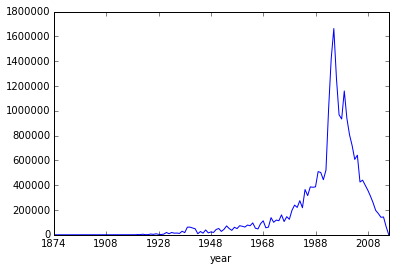

In [22]:
yearCountGroup.plot()

#### 2.3. What are the most watched movies?

This can be easily achieved by simply sorting the dataframe in descending order by the 'number of ratings' columns.

In [23]:
ratedMovies_df.sort(['number of ratings'], ascending = 0).head()

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,average rating,number of ratings,title,genres,year
movieId,,,,,
356,4.045156,81296,Forrest Gump,"[Comedy, Drama, Romance, War]",1994
296,4.163211,79091,Pulp Fiction,"[Comedy, Crime, Drama, Thriller]",1994
318,4.441710,77887,"Shawshank Redemption, The","[Crime, Drama]",1994
593,4.159838,76271,"Silence of the Lambs, The","[Crime, Horror, Thriller]",1991
480,3.652843,69545,Jurassic Park,"[Action, Adventure, Sci-Fi, Thriller]",1993


#### 2.4. What are the best genres by rating?

This is a bit more complicated than the other questions. So, every movie has genres and an average rating associated to it in our dataframe and we need to extract every individual genre and associate a rating to it. To do this, we have to iterate through every movie and then iterate through each genre associated to that movie and then create a dataframe that stores theses associations. This can achieved with the following code block:

In [24]:
buffer = []
ratedMovies_df.head()
for index, row in ratedMovies_df.iterrows():
    for genre in row.genres:
        buffer.append({'genre':genre, 'score':row['average rating']})

genresByScore = pd.DataFrame(buffer)
genresByScore.head()

,genre,score
0,Adventure,3.894802
1,Animation,3.894802
2,Children,3.894802
3,Comedy,3.894802
4,Fantasy,3.894802


With that done, we now only have to get the mean of the average rating after grouping it up by genre and then print it out for us to see:

In [25]:
averageGenreScore = genresByScore.groupby(['genre']).mean()

In [26]:
averageGenreScore.sort(['score'], ascending = 0).head()

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,score
genre,
Documentary,3.420446
Film-Noir,3.412199
IMAX,3.293740
War,3.268184
Drama,3.232944


#### 2.5. What are a user's preferred genres?

This is also a bit more complicated than the rest. We're trying to extract the user's favorite genres by averaging out their movie scores by genre and then showing the highest scores.

First, let's start by subsetting the ratings dataframe so we only have the specified user in it.

In [27]:
wantedUser = 5

userSubset = ratings_df.loc[wantedUser,:]

Now let's join this new subset with the movies dataframe. This new dataframe will contain every movie and its associated values that the specified user has watched and rated.

In [28]:
userSubsetRatings = userSubset.join(movies_df, on='movieId')

Let's take a look at it:

In [29]:
userSubsetRatings.head()

,movieId,rating,timestamp,title,genres,year
userId,,,,,,
5,1203,4.0,1440027024,12 Angry Men,[Drama],1957
5,2571,2.5,1440027038,"Matrix, The","[Action, Sci-Fi, Thriller]",1999
5,6016,5.0,1440027016,City of God (Cidade de Deus),"[Action, Adventure, Crime, Drama, Thriller]",2002
5,7502,4.5,1440027020,Band of Brothers,"[Action, Drama, War]",2001
5,58559,4.0,1440027029,"Dark Knight, The","[Action, Crime, Drama, IMAX]",2008


Now we simply have to redo what we did in the last question:

In [30]:
buffer = []
for index, row in userSubsetRatings.iterrows():
    for genre in row.genres:
        buffer.append({'genre':genre, 'score':row['rating']})
genresByScore = pd.DataFrame(buffer)

In [31]:
averageGenreScore = genresByScore.groupby(['genre']).mean()

And here are the user's top 5 favorite genres:

In [32]:
averageGenreScore.sort(['score'], ascending = 0).head()

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,score
genre,
Adventure,4.000000
Drama,3.966667
War,3.750000
Thriller,3.611111
Crime,3.500000


Author: Gabriel Garcez Barros Sousa